In [ ]:
import os
from tensorflow.keras.applications import (ResNet50, ResNet101, ResNet152,
                                           VGG16, VGG19,
                                           DenseNet121, DenseNet169, DenseNet201,
                                           EfficientNetB0, EfficientNetB7,
                                           InceptionV3)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

In [ ]:


# Paths and Parameters
DATASET_DIR = "/content/drive/MyDrive/Training"  # Update this path
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
CLASSES = ['Glioma', 'Meningioma', 'Pituitary Tumor', 'No Tumor']

In [ ]:


# Dynamically split dataset into train, validation, and test sets
def split_dataset(dataset_dir, train_split=0.7, test_split=0.15, valid_split=0.15):
    from glob import glob
    import shutil
    import random

    base_dir = "/content/dataset_split"
    train_dir = os.path.join(base_dir, "train")
    valid_dir = os.path.join(base_dir, "valid")
    test_dir = os.path.join(base_dir, "test")

    for directory in [train_dir, valid_dir, test_dir]:
        os.makedirs(directory, exist_ok=True)
        for class_dir in CLASSES:
            os.makedirs(os.path.join(directory, class_dir), exist_ok=True)

    for class_name in CLASSES:
        class_path = os.path.join(dataset_dir, class_name)
        images = glob(os.path.join(class_path, "*"))
        random.shuffle(images)

        train_count = int(len(images) * train_split)
        test_count = int(len(images) * test_split)

        train_images = images[:train_count]
        test_images = images[train_count:train_count + test_count]
        valid_images = images[train_count + test_count:]

        for image in train_images:
            shutil.copy(image, os.path.join(train_dir, class_name))
        for image in test_images:
            shutil.copy(image, os.path.join(test_dir, class_name))
        for image in valid_images:
            shutil.copy(image, os.path.join(valid_dir, class_name))

    print("Dataset split completed!")
    return train_dir, valid_dir, test_dir

train_dir, valid_dir, test_dir = split_dataset(DATASET_DIR)

Dataset split completed!


In [ ]:

# Data Generators
def load_data(train_dir, valid_dir, test_dir):
    datagen = ImageDataGenerator(rescale=1./255)

    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    valid_data = datagen.flow_from_directory(
        valid_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    return train_data, valid_data, test_data

In [ ]:
kaggle_train, kaggle_valid, kaggle_test = load_data(train_dir, valid_dir, test_dir)


Found 4914 images belonging to 4 classes.
Found 1057 images belonging to 4 classes.
Found 1052 images belonging to 4 classes.


In [ ]:




# Model Building Function
def build_model(architecture, input_shape=(224, 224, 3), num_classes=len(CLASSES)):
    architectures = {
        "ResNet50": ResNet50,
        "ResNet101": ResNet101,
        "ResNet152": ResNet152,
        "VGG16": VGG16,
        "VGG19": VGG19,
        "DenseNet121": DenseNet121,
        "DenseNet169": DenseNet169,
        "DenseNet201": DenseNet201,
        "EfficientNetB0": EfficientNetB0,
        "EfficientNetB7": EfficientNetB7,
        "InceptionV3": InceptionV3
    }

    if architecture not in architectures:
        raise ValueError(f"Invalid architecture: {architecture}")

    base_model = architectures[architecture](weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:


# Training and Evaluation Function
def train_and_evaluate(architecture, train_data, valid_data, test_data):
    print(f"Training {architecture}...")
    model = build_model(architecture)
    history = model.fit(
        train_data,
        validation_data=valid_data,
        epochs=EPOCHS
    )

    print(f"Evaluating {architecture}...")
    test_loss, test_acc = model.evaluate(test_data)
    print(f"Test Accuracy for {architecture}: {test_acc:.2f}")

    # Predictions and Metrics
    test_preds = model.predict(test_data)
    test_pred_labels = np.argmax(test_preds, axis=1)
    true_labels = test_data.classes

    print(f"Classification Report for {architecture}:")
    print(classification_report(true_labels, test_pred_labels, target_names=CLASSES))

    cm = confusion_matrix(true_labels, test_pred_labels)
    print("Confusion Matrix:")
    print(cm)

    try:
        roc_auc = roc_auc_score(true_labels, test_preds, multi_class='ovr')
        print(f"ROC-AUC for {architecture}: {roc_auc:.2f}")
    except Exception as e:
        print(f"ROC-AUC could not be calculated: {e}")

    # Confusion Matrix Visualization
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {architecture}")
    plt.show()

    return model, history

In [ ]:


# Grad-CAM Visualization Function
def grad_cam_visualization(model, image_path, target_layer_name):
    print(f"Running Grad-CAM for {target_layer_name}...")

    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)

    grad_model = tf.keras.models.Model(
        inputs=[model.input],
        outputs=[model.get_layer(target_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)

    heatmap = tf.image.resize(heatmap, IMG_SIZE)
    heatmap = heatmap.numpy()

    overlay = img_to_array(img) / 255.0
    overlay = np.squeeze(overlay)

    plt.imshow(overlay)
    plt.imshow(heatmap.squeeze(), cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title("Grad-CAM Visualization")
    plt.show()

Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


154/154 ━━━━━━━━━━━━━━━━━━━━ 138s 502ms/step - accuracy: 0.8477 - loss: 0.3849 - val_accuracy: 0.2838 - val_loss: 5.8278
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 47s 299ms/step - accuracy: 0.9856 - loss: 0.0428 - val_accuracy: 0.2838 - val_loss: 5.2529
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 296ms/step - accuracy: 0.9896 - loss: 0.0299 - val_accuracy: 0.2848 - val_loss: 6.6545
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 298ms/step - accuracy: 0.9875 - loss: 0.0388 - val_accuracy: 0.4418 - val_loss: 2.1996
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 297ms/step - accuracy: 0.9955 - loss: 0.0180 - val_accuracy: 0.6358 - val_loss: 0.9887
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 298ms/step - accuracy: 0.9933 - loss: 0.0181 - val_accuracy: 0.8467 - val_loss: 0.4369
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 298ms/step - accuracy: 0.9955 - loss: 0.0155 - val_accuracy: 0.9111 - val_loss: 0.2941
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 298ms/step - accuracy: 0.9983 - loss: 0.0065 - va

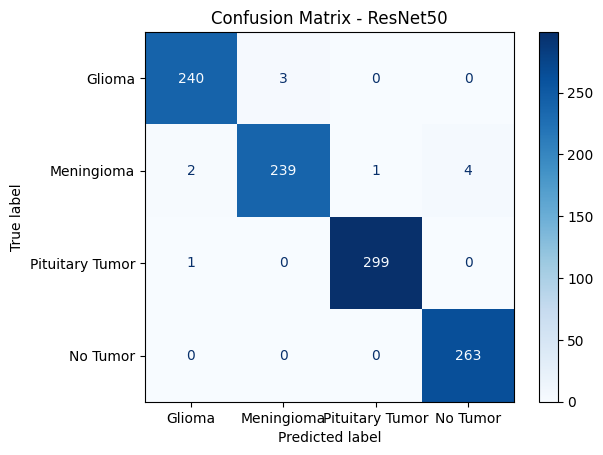

Running Grad-CAM for conv5_block3_out...


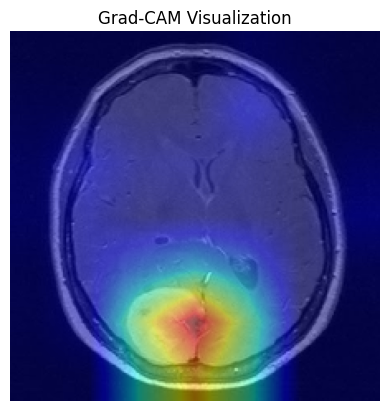

In [ ]:


# Train and Evaluate All Models
architectures = ["ResNet50"]

for architecture in architectures:
    model, history = train_and_evaluate(architecture, kaggle_train, kaggle_valid, kaggle_test)

    # Grad-CAM Integration
    test_image_path = "/content/Te-me_0010.jpg"  # Replace with your test image path
    grad_cam_visualization(model, test_image_path, target_layer_name='conv5_block3_out')  # Replace with actual target layer name

Training ResNet152...
234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.8653 - loss: 0.3611 - val_accuracy: 0.2346 - val_loss: 13.8947
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 117s 758ms/step - accuracy: 0.9820 - loss: 0.0564 - val_accuracy: 0.2621 - val_loss: 10.4744
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 116s 753ms/step - accuracy: 0.9871 - loss: 0.0475 - val_accuracy: 0.2602 - val_loss: 14.0335
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 116s 753ms/step - accuracy: 0.9860 - loss: 0.0373 - val_accuracy: 0.3586 - val_loss: 6.8407
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 116s 753ms/step - accuracy: 0.9944 - loss: 0.0163 - val_accuracy: 0.4153 - val_loss: 5.7746
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 117s 754ms/step - accuracy: 0.9956 - loss: 0.0152 - val_accuracy: 0.6282 - val_loss: 4.9271
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 142s 756ms/step - accuracy: 0.9865 - loss: 0.0516 - val_accuracy: 0.8751 - val_loss: 0.3789


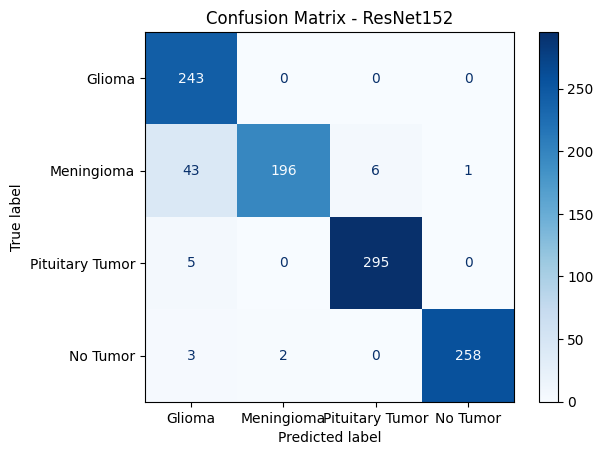

Running Grad-CAM for conv5_block3_out...


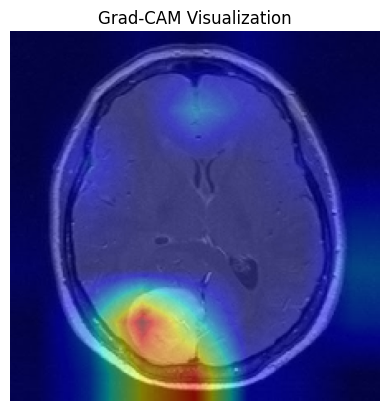

In [ ]:


# Train and Evaluate All Models
architectures = ["ResNet152"]

for architecture in architectures:
    model, history = train_and_evaluate(architecture, kaggle_train, kaggle_valid, kaggle_test)

    # Grad-CAM Integration
    test_image_path = "/content/Te-me_0010.jpg"  # Replace with your test image path
    grad_cam_visualization(model, test_image_path, target_layer_name='conv5_block3_out')  # Replace with actual target layer name

Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


154/154 ━━━━━━━━━━━━━━━━━━━━ 152s 745ms/step - accuracy: 0.6417 - loss: 0.8210 - val_accuracy: 0.9158 - val_loss: 0.2319
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 78s 504ms/step - accuracy: 0.9347 - loss: 0.1873 - val_accuracy: 0.9518 - val_loss: 0.1510
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 80s 517ms/step - accuracy: 0.9533 - loss: 0.1215 - val_accuracy: 0.9480 - val_loss: 0.1653
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 80s 518ms/step - accuracy: 0.9702 - loss: 0.0844 - val_accuracy: 0.9584 - val_loss: 0.1113
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 80s 517ms/step - accuracy: 0.9825 - loss: 0.0554 - val_accuracy: 0.9754 - val_loss: 0.0764
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 80s 517ms/step - accuracy: 0.9875 - loss: 0.0355 - val_accuracy: 0.9716 - val_loss: 0.0927
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 80s 517ms/step - accuracy: 0.9743 - loss: 0.0793 - val_accuracy: 0.9820 - val_loss: 0.0610
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 80s 516ms/step - accuracy: 0.9915 - loss: 0.0243 - va

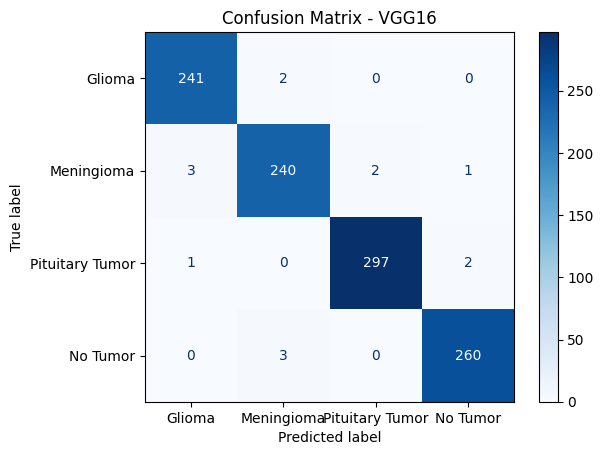

Running Grad-CAM for block5_conv3...


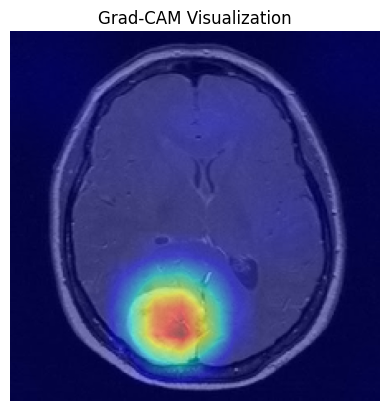

In [ ]:


# Train and Evaluate All Models
architectures = ["VGG16"]

for architecture in architectures:
    model, history = train_and_evaluate(architecture, kaggle_train, kaggle_valid, kaggle_test)

    # Grad-CAM Integration
    test_image_path = "/content/Te-me_0010.jpg"  # Replace with your test image path
    grad_cam_visualization(model, test_image_path, target_layer_name='block5_conv3')  # Replace with actual target layer name

Training VGG19...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 108s 654ms/step - accuracy: 0.5284 - loss: 1.0519 - val_accuracy: 0.8666 - val_loss: 0.3998
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 97s 624ms/step - accuracy: 0.8564 - loss: 0.3904 - val_accuracy: 0.9196 - val_loss: 0.1960
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 97s 625ms/step - accuracy: 0.9328 - loss: 0.2003 - val_accuracy: 0.9574 - val_loss: 0.1276
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 96s 624ms/step - accuracy: 0.9562 - loss: 0.1311 - val_accuracy: 0.9688 - val_loss: 0.0881
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 96s 624ms/step - accuracy: 0.9633 - loss: 0.1196 - val_accuracy: 0.9612 - val_loss: 0.1147
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 96s 623ms/step - accuracy: 0.9774 - loss: 0.0668 - val_accuracy: 0.9716 - val_loss: 0.0759
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 96s 621ms/step - accuracy: 0.9781 - loss: 0.0591 - val_accuracy: 0.9735 - val_loss: 0.0805
Epoch 8/10
15

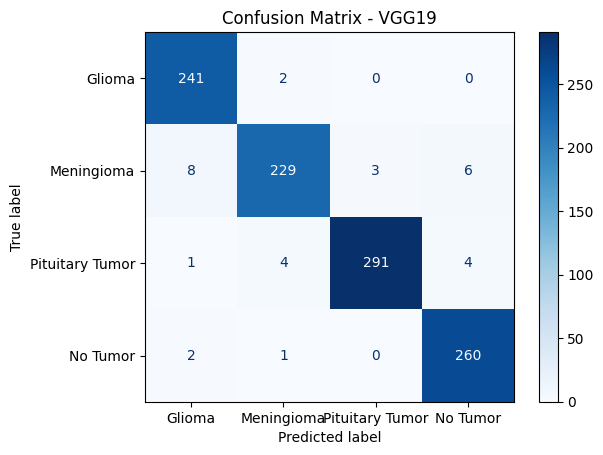

Running Grad-CAM for block5_conv4...


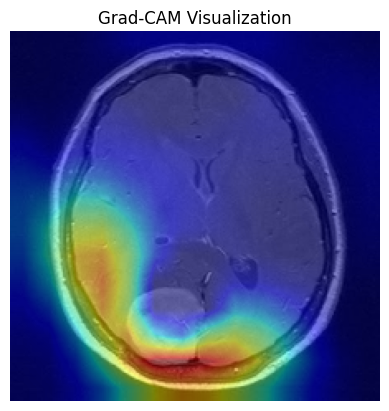

In [ ]:


# Train and Evaluate All Models
architectures = ["VGG19"]

for architecture in architectures:
    model, history = train_and_evaluate(architecture, kaggle_train, kaggle_valid, kaggle_test)

    # Grad-CAM Integration
    test_image_path = "/content/Te-me_0010.jpg"  # Replace with your test image path
    grad_cam_visualization(model, test_image_path, target_layer_name='block5_conv4')  # Replace with actual target layer name

Training DenseNet121...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 300s 988ms/step - accuracy: 0.8449 - loss: 0.4218 - val_accuracy: 0.8940 - val_loss: 0.2983
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 45s 288ms/step - accuracy: 0.9843 - loss: 0.0517 - val_accuracy: 0.9300 - val_loss: 0.1854
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 45s 291ms/step - accuracy: 0.9955 - loss: 0.0172 - val_accuracy: 0.9745 - val_loss: 0.0931
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 296ms/step - accuracy: 0.9939 - loss: 0.0176 - val_accuracy: 0.9461 - val_loss: 0.1761
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 298ms/step - accuracy: 0.9962 - loss: 0.0138 - val_accuracy: 0.9565 - val_loss: 0.1447
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 299ms/step - accuracy: 0.9958 - loss: 0.0158 - val_accuracy: 0.9886 - val_loss: 0.0550
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 46s 298ms/step - accuracy: 0.9960 - loss: 0.0177 - val_accuracy: 0.9811 - val_loss: 0.0826
Epoch 8

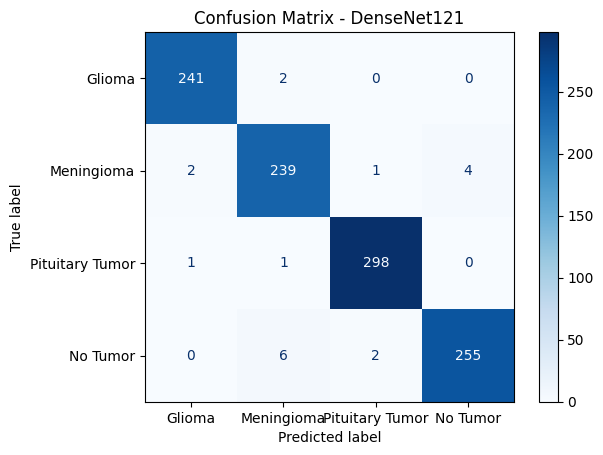

Running Grad-CAM for conv5_block16_concat...


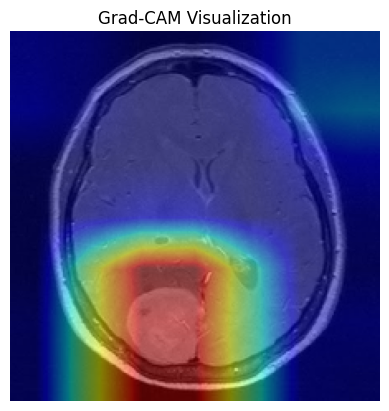

In [ ]:


# Train and Evaluate All Models
architectures = ["DenseNet121"]

for architecture in architectures:
    model, history = train_and_evaluate(architecture, kaggle_train, kaggle_valid, kaggle_test)

    # Grad-CAM Integration
    test_image_path = "/content/Te-me_0010.jpg"  # Replace with your test image path
    grad_cam_visualization(model, test_image_path, target_layer_name='conv5_block16_concat')  # Replace with actual target layer name

Training EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 148s 495ms/step - accuracy: 0.7650 - loss: 0.6590 - val_accuracy: 0.2441 - val_loss: 1.4113
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.9651 - loss: 0.1096 - val_accuracy: 0.2753 - val_loss: 1.3048
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.9834 - loss: 0.0507 - val_accuracy: 0.4551 - val_loss: 1.3467
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - accuracy: 0.9926 - loss: 0.0237 - val_accuracy: 0.5383 - val_loss: 1.4891
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - accuracy: 0.9950 - loss: 0.0177 - val_accuracy: 0.8524 - val_loss: 0.4836
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.9963 - loss: 0.0116 - val_accuracy: 0.9234 - val_loss: 0.2209
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.9945 - loss: 0.0153 - val_accuracy: 0.9811 - val_loss: 0.0789
Epoc

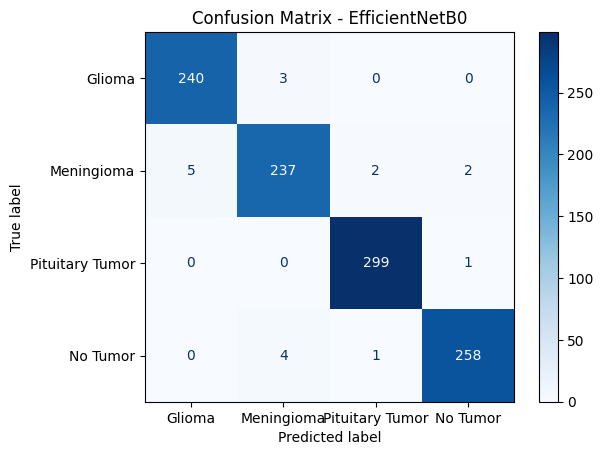

Running Grad-CAM for top_conv...


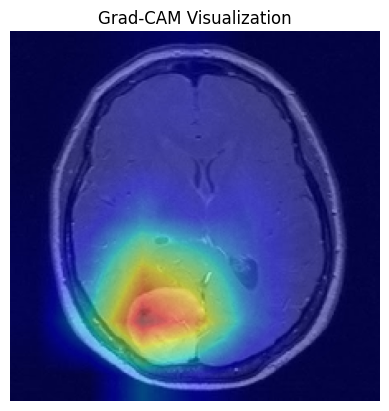

In [ ]:


# Train and Evaluate All Models
architectures = ["EfficientNetB0"]

for architecture in architectures:
    model, history = train_and_evaluate(architecture, kaggle_train, kaggle_valid, kaggle_test)

    # Grad-CAM Integration
    test_image_path = "/content/Te-me_0010.jpg"  # Replace with your test image path
    grad_cam_visualization(model, test_image_path, target_layer_name='top_conv')  # Replace with actual target layer name

Training InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 157s 536ms/step - accuracy: 0.8166 - loss: 0.4985 - val_accuracy: 0.9035 - val_loss: 0.2850
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 35s 224ms/step - accuracy: 0.9852 - loss: 0.0499 - val_accuracy: 0.9536 - val_loss: 0.1461
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 35s 227ms/step - accuracy: 0.9881 - loss: 0.0425 - val_accuracy: 0.9763 - val_loss: 0.0850
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 36s 229ms/step - accuracy: 0.9921 - loss: 0.0265 - val_accuracy: 0.9792 - val_loss: 0.0861
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 36s 230ms/step - accuracy: 0.9958 - loss: 0.0149 - val_accuracy: 0.9726 - val_loss: 0.1262
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 36s 230ms/step - accuracy: 0.9888 - loss: 0.0431 - val_accuracy: 0.9669 - val_loss: 0.0882
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 36s 230ms/step - accuracy: 0.9939 - loss: 0.0188 - val_accuracy: 0.9915 - val_loss: 0.0399
Epoch 8

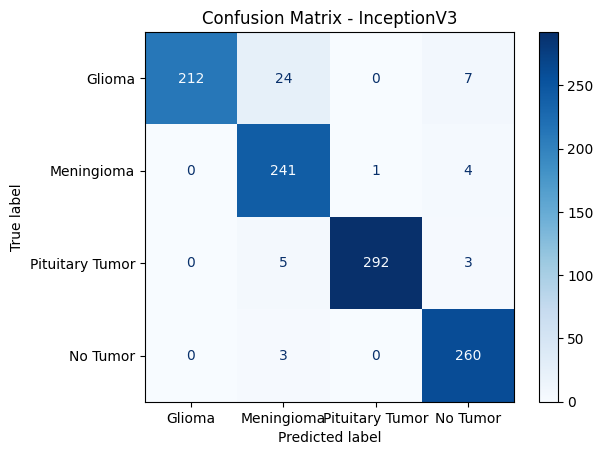

Running Grad-CAM for mixed10...


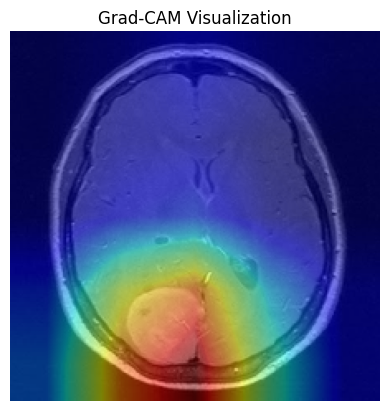

In [ ]:


# Train and Evaluate All Models
architectures = ["InceptionV3"]

for architecture in architectures:
    model, history = train_and_evaluate(architecture, kaggle_train, kaggle_valid, kaggle_test)

    # Grad-CAM Integration
    test_image_path = "/content/Te-me_0010.jpg"  # Replace with your test image path
    grad_cam_visualization(model, test_image_path, target_layer_name='mixed10')  # Replace with actual target layer name